In [1]:
###Hide
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain

## Data Source 2

### Summary of data

*ID*  Patient identification number

*Y1*  Number of epilepsy attacks patients have during the first follow-up period

*Y2*  Number of epilepsy attacks patients have during the second follow-up period

*Y3*  Number of epilepsy attacks patients have during the third follow-up period

*Y4*  Number of epilepsy attacks patients have during the forth follow-up period

*Base*  Number of epileptic attacks recorded during 8 week period prior to randomization

*Age*  Age of the patients

*Treatment*  A factor with levels placebo progabide indicating whether the anti-epilepsy drug Progabide has been applied or not (0=Placebo, 1=Progabide)

In [2]:
#Load the data 
seizure_raw = pd.read_csv('datasets/seizure.csv', delimiter=',')
#Check out the data - sanity check
print "Shape of data:" , seizure_raw.shape
seizure_raw.head()

Shape of data: (59, 8)


,Unnamed: 0,y1,y2,y3,y4,trt,base,age
0,1,5,3,3,3,0,11,31
1,2,3,5,3,3,0,11,30
2,3,2,4,0,5,0,6,25
3,4,4,4,1,4,0,8,36
4,5,7,18,9,21,0,66,22


In [3]:
#clean up data
seizure_raw.columns=['ID','y1','y2','y3','y4','treatment','base','age']
print seizure_raw.shape
seizure_raw.head()

(59, 8)


,ID,y1,y2,y3,y4,treatment,base,age
0,1,5,3,3,3,0,11,31
1,2,3,5,3,3,0,11,30
2,3,2,4,0,5,0,6,25
3,4,4,4,1,4,0,8,36
4,5,7,18,9,21,0,66,22


In [4]:
#let's take a look at the summary statistics of the data
seizure_raw.describe()

,ID,y1,y2,y3,y4,treatment,base,age
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,30.000000,8.949153,8.355932,8.440678,7.338983,0.525424,31.237288,28.847458
std,17.175564,14.835214,10.187488,14.148561,9.637588,0.503640,26.883747,7.619878
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,18.000000
25%,15.500000,2.000000,3.000000,2.000000,3.000000,0.000000,12.000000,22.500000
50%,30.000000,4.000000,5.000000,4.000000,5.000000,1.000000,22.000000,28.000000
75%,44.500000,10.500000,11.500000,8.000000,8.000000,1.000000,41.500000,33.500000
max,59.000000,102.000000,65.000000,76.000000,63.000000,1.000000,151.000000,57.000000


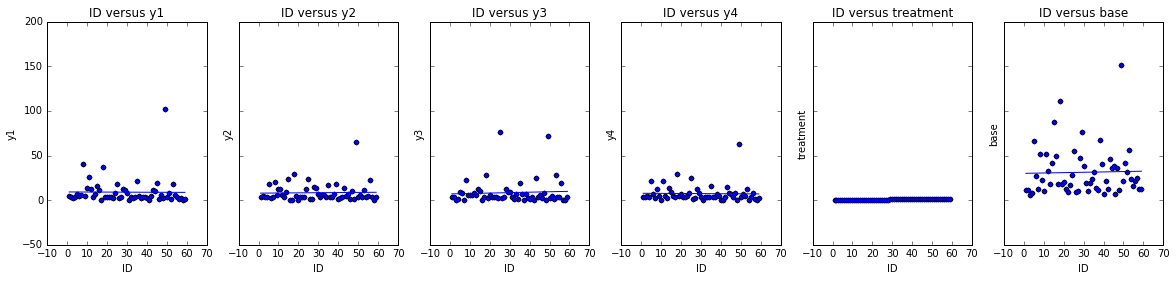

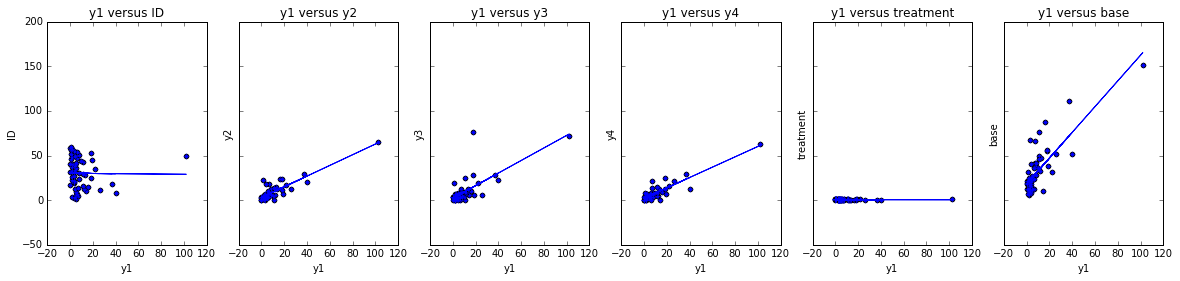

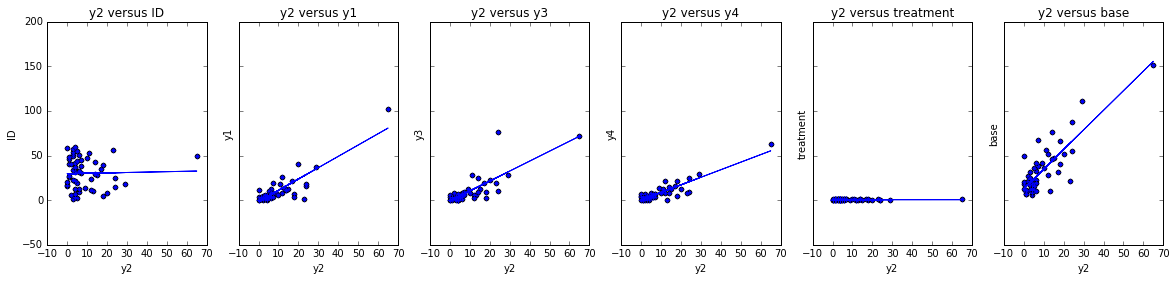

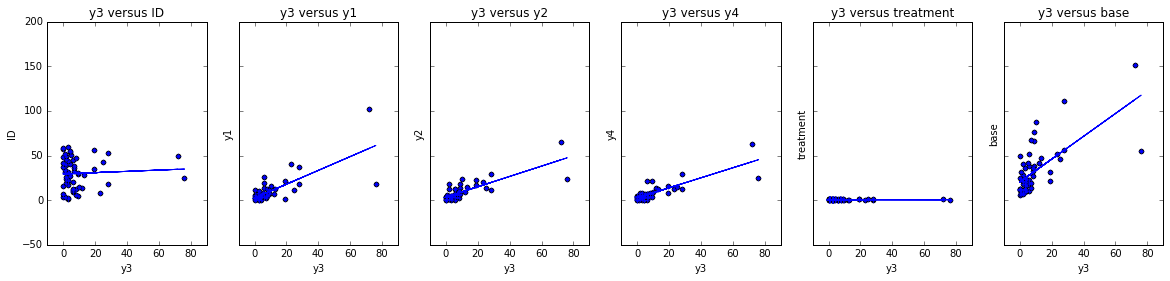

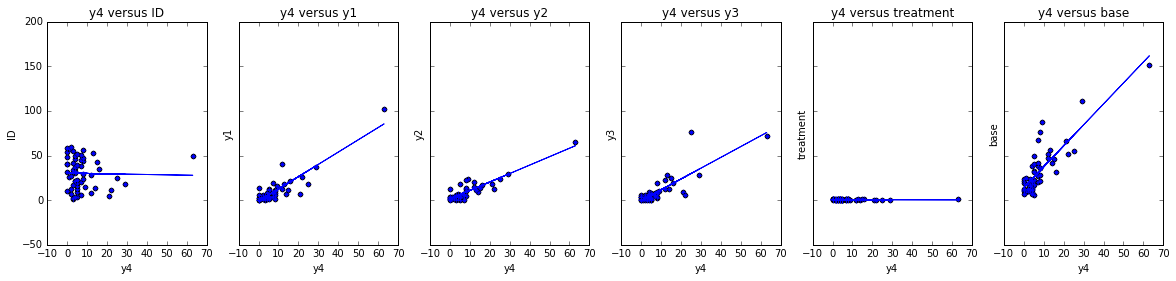

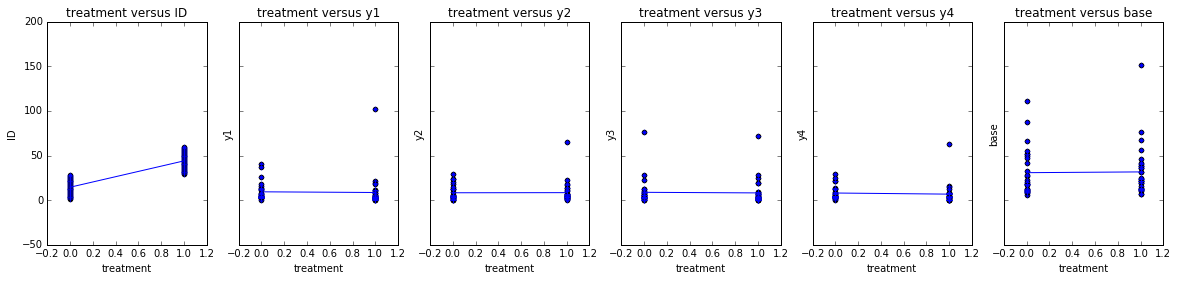

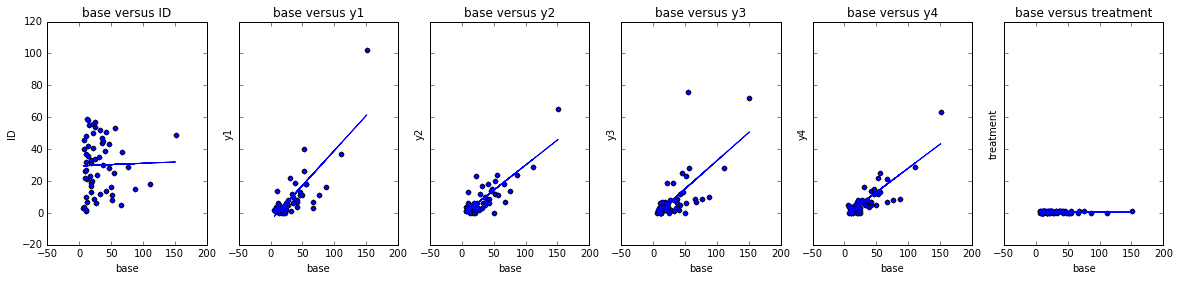

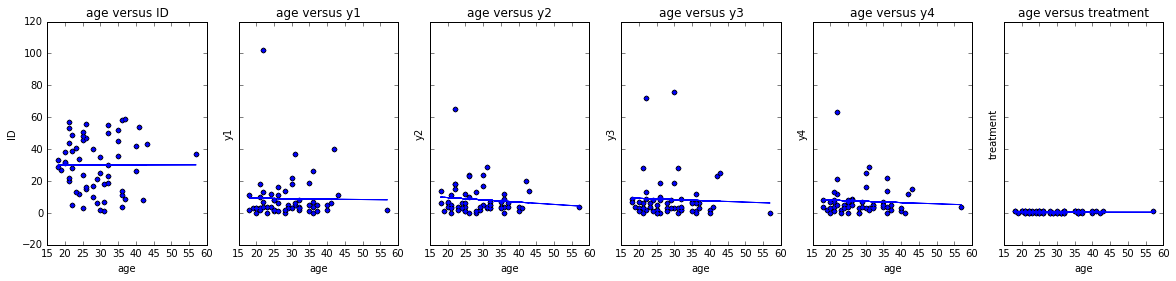

In [8]:
# Visulaize

columns=list(seizure_raw)
for x_column in columns:
    cols = columns[:]
    cols.remove(x_column)

    fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(20,4))

    for y_column, ax in zip(cols, axes):
        if y_column != x_column:
            x = seizure_raw[x_column]
            y = seizure_raw[y_column]
            fit = np.polyfit(x, y, 1)
            fitx = np.poly1d(fit)
            ax.plot(x, y, 'b+', x, fitx(x),'b-')
            ax.set_xlabel(x_column)
            ax.set_ylabel(y_column)
            ax.set_title(x_column + ' versus ' + y_column)
            ax.scatter(x,y)
    plt.show()

So we do see the trendlines decreasing in the weeks where treatments were in place above.

In [9]:
# Add a basey column which sums all the y periodicity
seizure_raw['basey'] = seizure_raw['y1']+seizure_raw['y2']+seizure_raw['y3']+seizure_raw['y4']

In [10]:
# let's tweak the data a bit more
seizure_df=pd.melt(seizure_raw,id_vars=['ID', 'treatment','age'], var_name='quantity').sort_values(by=['ID', 'quantity'])
seizure_df.head()

,ID,treatment,age,quantity,value
236,1,0,31,base,11
295,1,0,31,basey,14
0,1,0,31,y1,5
59,1,0,31,y2,3
118,1,0,31,y3,3


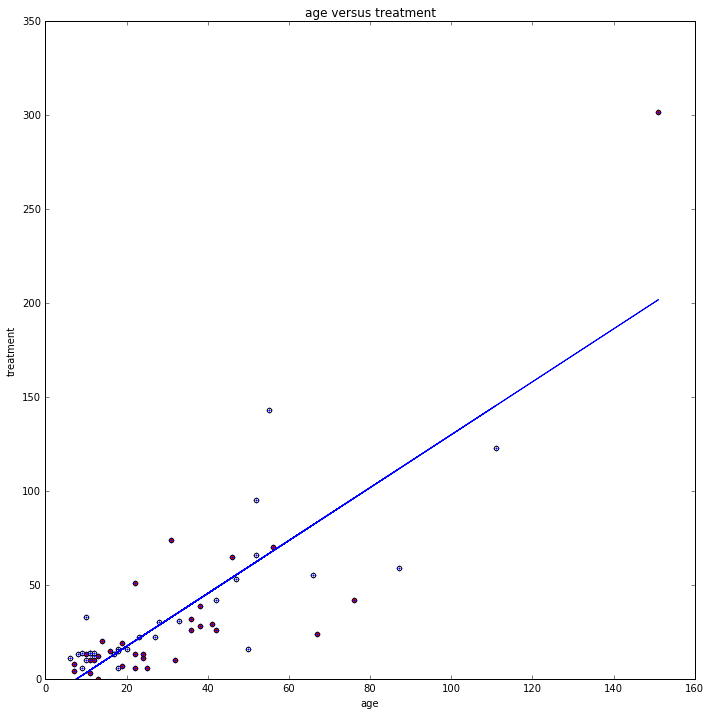

In [11]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['base']
y = seizure_raw['basey']
z = seizure_raw['treatment']
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel(x_column)
ax.set_ylabel(y_column)
ax.set_title(x_column + ' versus ' + y_column)
#   ax.scatter(x,y)
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide')
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo')
plt.tight_layout()
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
plt.show()

The red dots show that treatment is effectice in this sample

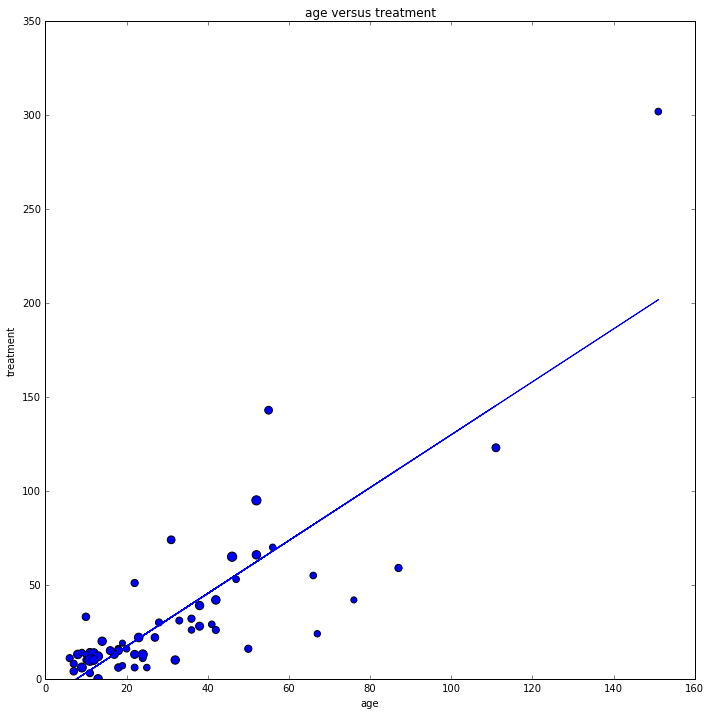

In [12]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['base']
y = seizure_raw['basey']
z = seizure_raw['age']
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel(x_column)
ax.set_ylabel(y_column)
ax.set_title(x_column + ' versus ' + y_column)
#   ax.scatter(x,y)
#Plot age as dot size
ax.scatter(x, y, s=z*2)
plt.tight_layout()
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
plt.show()

I really should plot the median of base against y1-y4 over time by patient

And I should look at the deltas

In [14]:
deltas_df = pd.concat([seizure_raw['ID'], seizure_raw['y1'], seizure_raw['y2'], seizure_raw['y3'], seizure_raw['y4'], seizure_raw['base'], seizure_raw['treatment'],seizure_raw['age']], axis=1)
# deltas_df['delta1'] = seizure_raw.apply(seizure_raw['y1']-(seizure_raw['base'])/4)
deltas_df['basey'] = seizure_raw['y1']+seizure_raw['y2']+seizure_raw['y3']+seizure_raw['y4']
deltas_df.head()

,ID,y1,y2,y3,y4,base,treatment,age,basey
0,1,5,3,3,3,11,0,31,14
1,2,3,5,3,3,11,0,30,14
2,3,2,4,0,5,6,0,25,11
3,4,4,4,1,4,8,0,36,13
4,5,7,18,9,21,66,0,22,55


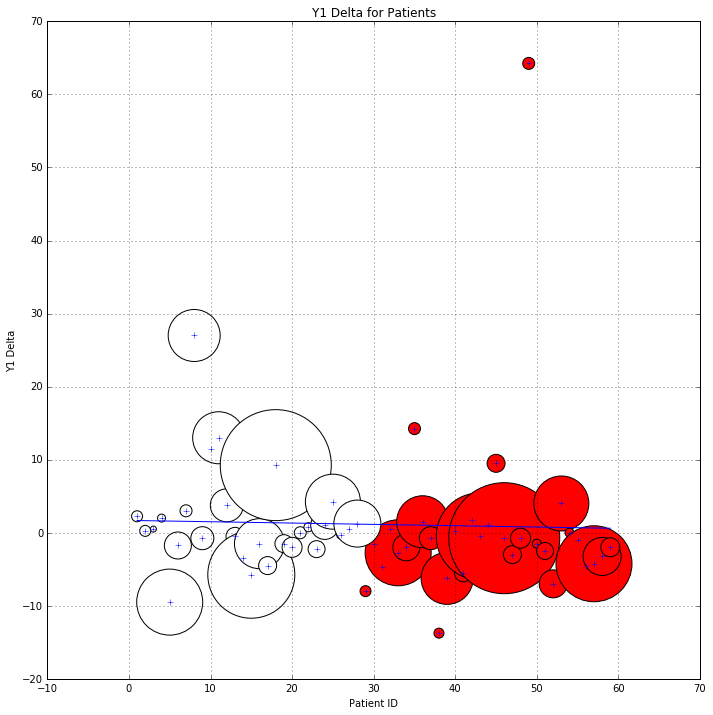

In [15]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y1']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y1 Delta')
ax.set_title('Y1 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

I was trying to show if the patient had a large baseline to begin with above.  The trendline is down.

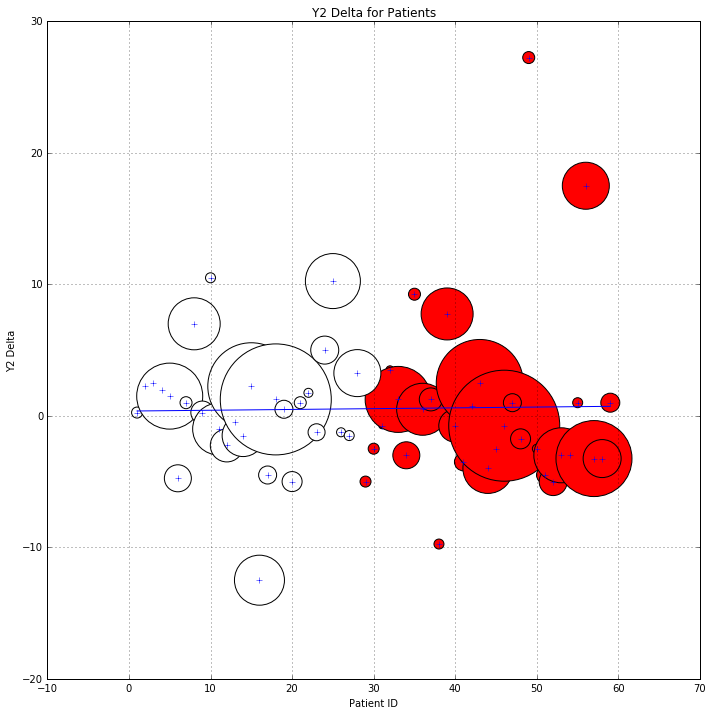

In [16]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y2']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y2 Delta')
ax.set_title('Y2 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

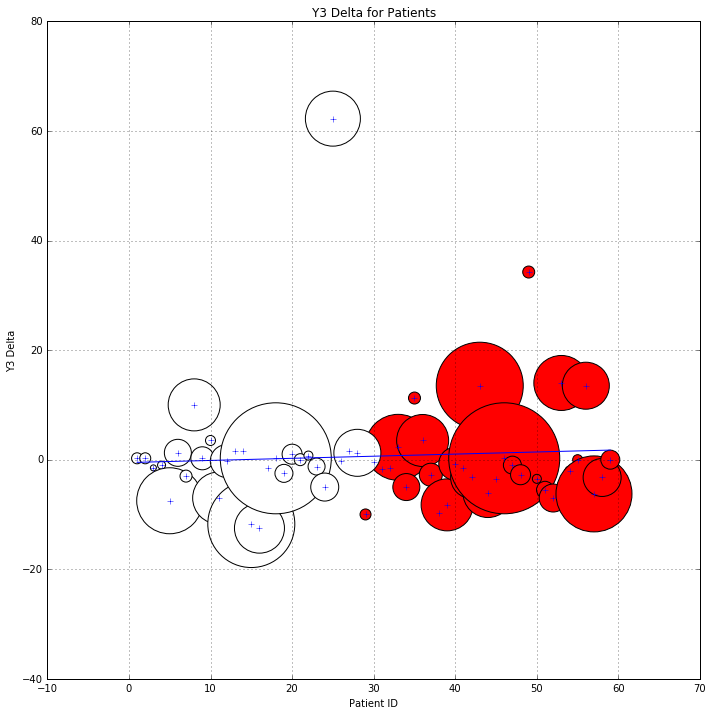

In [17]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y3']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y3 Delta')
ax.set_title('Y3 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

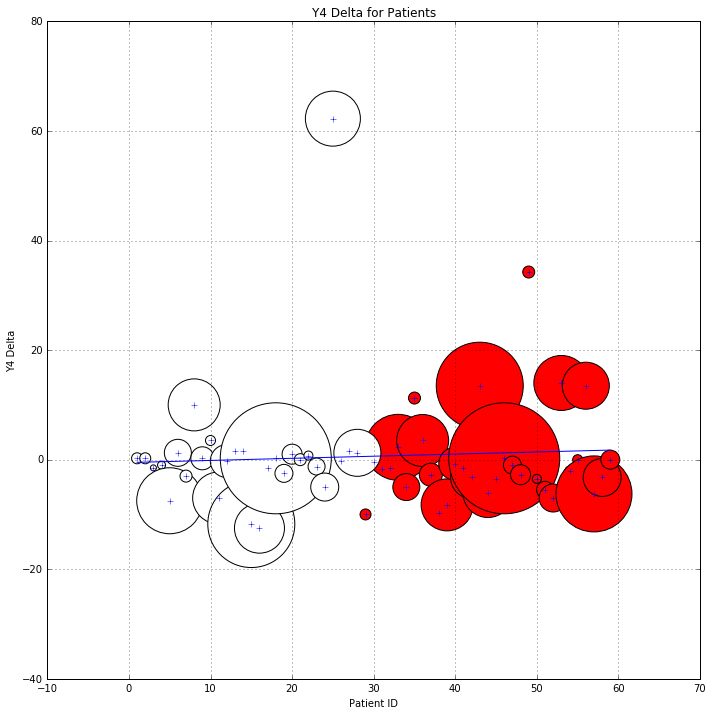

In [18]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['y3']-(seizure_raw['base']/4)
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('Y4 Delta')
ax.set_title('Y4 Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

Not so conclusive for the other weeks.  Need to look at age perhaps?

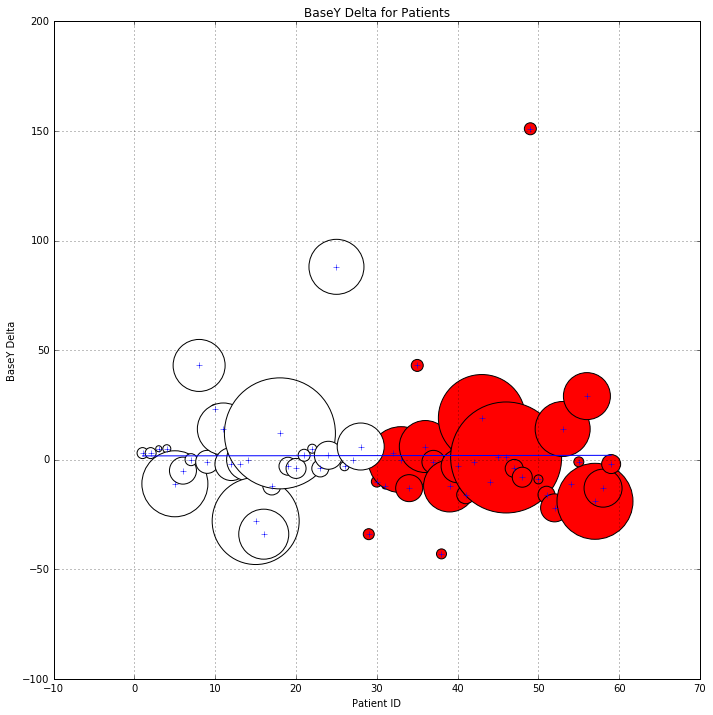

In [19]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['basey']-(seizure_raw['base'])
z = seizure_raw['treatment']
size = (seizure_raw['base'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('BaseY Delta')
ax.set_title('BaseY Delta for Patients')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()

Overall pretty flat.

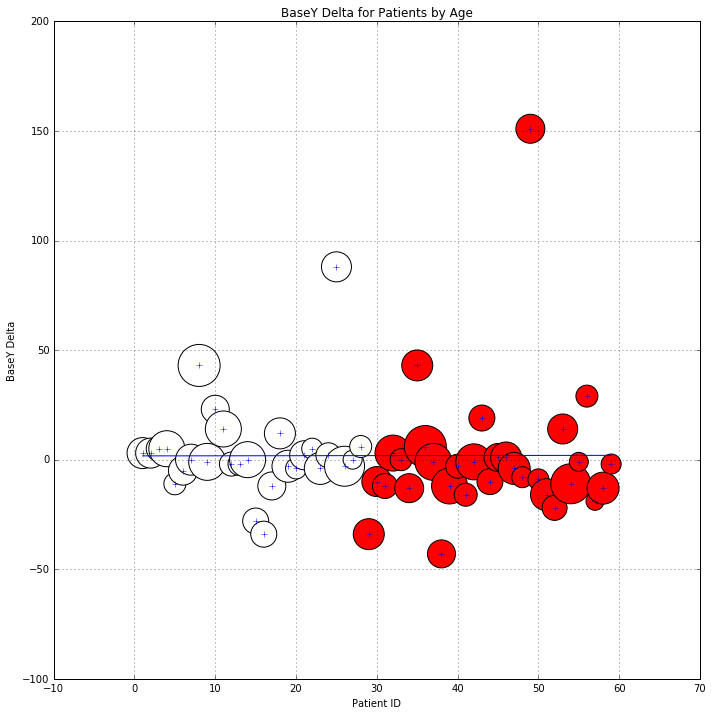

In [20]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

x = seizure_raw['ID']
y = seizure_raw['basey']-(seizure_raw['base'])
z = seizure_raw['treatment']
size = (seizure_raw['age'])
fit = np.polyfit(x, y, 1)
fitx = np.poly1d(fit)
ax.plot(x, y, 'b+', x, fitx(x),'b-')
ax.set_xlabel('Patient ID')
ax.set_ylabel('BaseY Delta')
ax.set_title('BaseY Delta for Patients by Age')
#Plot Progabide locations as green dots
ax.scatter(x[z == 1], y[z == 1], c='red', label='Progabide',s=size**2)
#Plot placebo locations as white dots
ax.scatter(x[z == 0], y[z == 0], c='white', label='placebo',s=size**2)
# ax.scatter(x, y)
plt.grid(True)
plt.tight_layout()
plt.show()